In [1]:
import sys
sys.path.append('../src')
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.special import erfinv
from sparse_coding_model import SparseCoding, normalize01
from utils import *
from train_funcs import load_models, generate_HVC
from sklearn.decomposition import DictionaryLearning
rng = np.random.default_rng()

In [2]:
fname = '../realistic_auditory_processing/learned_song_responses.npz'
T_SONG = np.load(fname)['ctrl'].shape[2] # (n_songs, N, T)

In [3]:
adult = dict(np.load('../adult_songs/data.npz'))
n_samples, n_syl, n_freq_bins, n_time_bins = adult['spec_syl'].shape
# xmin = adult['spec_syl'].min(axis=(0,2,3), keepdims=True) # syl-wise norm
# xmax = adult['spec_syl'].max(axis=(0,2,3), keepdims=True)
# adult['spec_syl'] = (adult['spec_syl'] - xmin) / (xmax - xmin)

In [4]:
n_basis = 20
n_trunc_bins = 4
basis = np.zeros((n_basis, n_trunc_bins*n_time_bins))
coefs = np.zeros((n_samples*n_syl*n_trunc_bins, n_basis))
dl = DictionaryLearning(n_components=n_basis, alpha=0.1, 
                        fit_algorithm='cd', transform_algorithm='lasso_cd',
                        max_iter=int(1e3), positive_dict=True, positive_code=True)
aux = []
for k in range(n_samples):
    for i in range(n_syl):
        for j in range(0, n_time_bins, n_trunc_bins):
            _ = adult['spec_syl'][k,i,:,j:j+n_trunc_bins].flatten()
            if not np.allclose(_, 0):
                aux.append(_)
aux = np.stack(aux)
coefs = dl.fit_transform(aux)
# a_std = coefs.std(axis=0)[None,:]
# coefs /= a_std
basis = dl.components_# * a_std.T

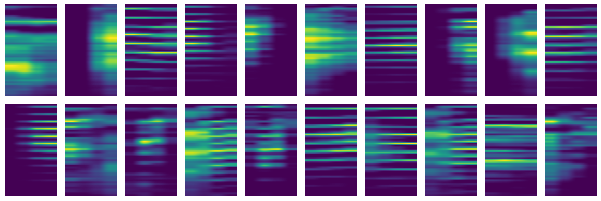

In [5]:
fig, ax = plt.subplots(2, 10, figsize=(6, 2))
ax = ax.flatten()
for i, b in enumerate(basis):
    if i >= len(ax):
        break
    ax[i].imshow(b.reshape(n_freq_bins, n_trunc_bins))
    ax[i].set_axis_off()

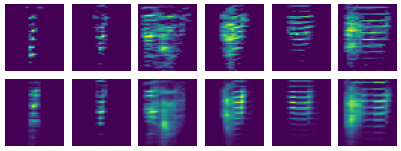

In [6]:
fig, ax = plt.subplots(2, n_syl, figsize=(4,1.5))
for i in range(n_syl):
    k = rng.integers(0,n_samples)
    ax[0,i].imshow(adult['spec_syl'][j,i])
    spec = np.zeros((n_freq_bins, n_time_bins))
    for j in range(0, n_time_bins, n_trunc_bins):
        _ = adult['spec_syl'][k,i,:,j:j+n_trunc_bins].flatten()[None,:]
        if not np.allclose(_, 0):
            recon = np.round(dl.transform(_)).clip(0, 10) @ basis
            spec[:,j:j+n_trunc_bins] = recon.reshape(n_freq_bins, -1)
    ax[1,i].imshow(spec)
    ax[0,i].set_axis_off()
    ax[1,i].set_axis_off()

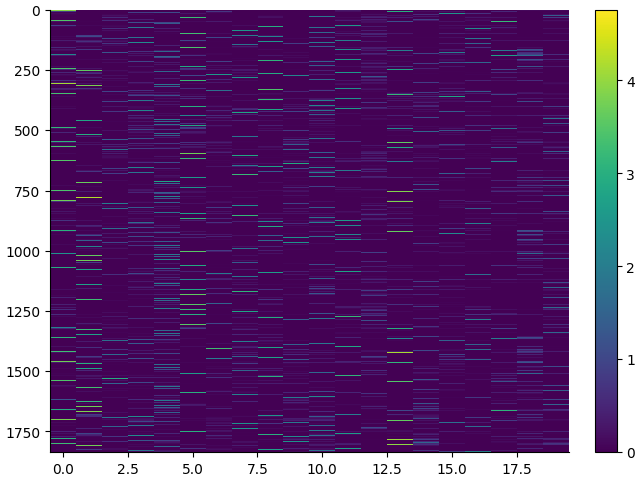

In [7]:
plt.imshow(coefs, interpolation='none')
plt.colorbar()
# fig, ax = plt.subplots(n_syl, figsize=(5, 6), sharex='all')
# for i in range(n_syl):
#     _ = coefs[i*n_samples:(i+1)*n_samples]
#     ax[i].errorbar(np.arange(n_basis_per_syl*n_syl), _.mean(axis=0), yerr=_.std(axis=0))

In [8]:
class Environment:
    VOCAL_ERR_NET_MAP = {'FF': 0, 'EI-HVC2E': 1, 'EI-E2E': 2, 'EI-E2I2E': 3}
    def __init__(self, action_basis, n_time_bins, n_trunc_bins, T_song, 
                 dir_sensory_net, dir_vocal_error_net, vocal_error_net_type, 
                 T_burn=500, T_post=200, spec_dt=10,
                 HVC_peak_rate=150, HVC_kernel_width=20):
        # Constants
        self.T_song = T_song
        self.T_burn = T_burn
        self.T_post = T_post
        self.T = T_burn + T_song + T_post
        self.spec_dt = spec_dt
        self.n_trunc_bins = n_trunc_bins
        
        # Store action basis
        # (n_basis, n_freq_bins*n_time_bins)
        self.action_basis = action_basis
        # self.action_basis = np.concatenate(action_basis, axis=0) 
        self.action_dim = self.action_basis.shape[0]
        
        # Load sensory net
        sensory_basis = torch.load(dir_sensory_net)
        assert sensory_basis.shape[0] % n_time_bins == 0
        self.n_sensory_basis = sensory_basis.shape[1]
        self.n_time_bins = n_time_bins
        self.n_freq_bins = sensory_basis.shape[0] // n_time_bins
        self.sensory = SparseCoding(n_basis=self.n_sensory_basis, 
                                    n_freq_bins=self.n_freq_bins, 
                                    n_time_bins=self.n_time_bins)
        self.sensory.basis = sensory_basis

        # Load vocal error net
        ret = load_models(dir_vocal_error_net, 'neighbor', 'EIIE', 'mature_hvc', 0)
        self.ve_net = ret[Environment.VOCAL_ERR_NET_MAP[vocal_error_net_type]]
        self.sensory_mapping = ret[-1]
        self.ve_net_in_dim, self.HVC_dim = self.ve_net.W.shape
        
        # Construct states from HVC firing
        burst_ts = np.linspace(T_burn, T_burn+T_song, num=self.HVC_dim, endpoint=False)
        aux = np.zeros((self.HVC_dim,1))
        self.rH = generate_HVC(T_burn+T_song+T_post, burst_ts[:,None], 
                               HVC_peak_rate+aux, HVC_kernel_width+aux)
        
        self.states = list(range(T_song//(spec_dt*n_trunc_bins)))
        self.state_dim = len(self.states)

        # Buffers
        self._cur_state = 0
        self._last_silence = -1
        self._song_spec = np.zeros((self.n_freq_bins, (T_song+T_post)//spec_dt))
        self._song_emb = np.zeros((T_song+T_post, self.ve_net_in_dim))

    def _get_emb(self):
        i = (self._last_silence + 1) * self.n_trunc_bins
        j = self._cur_state * self.n_trunc_bins
        if j == i: # consecutive silence
            return 
        bos = np.zeros((self.n_freq_bins, self.n_time_bins))
        pad = self.n_time_bins - (j - i)
        bos[:,pad//2:pad//2+j-i] = self._song_spec[:,i:j]
        if np.allclose(bos, 0, atol=1e-4):
            emb = np.zeros(self.sensory_mapping.shape[-1])
        else:
            emb = self.sensory(torch.tensor(bos, dtype=torch.float32), n_iter_coef=200)
            emb = np.squeeze(emb.numpy()) @ self.sensory_mapping
            self._song_emb[i*self.spec_dt:j*self.spec_dt] = emb
        if np.isnan(emb).any():
            plt.imshow(bos)
    
    def reset(self):
        self._cur_state = 0
        self._last_silence = -1
        self._song_spec[:] = 0
        self._song_emb[:] = 0
        return 0

    def must_silence(self):
        return self._cur_state - self._last_silence > self.n_time_bins / self.n_trunc_bins
        
    def step(self, action, song_spec=False):
        if self._cur_state >= len(self.states): # already done
            return None, True

        last = self._cur_state + 1 == len(self.states)
        if np.allclose(action, 0) or last: # silence or end
            bos = np.zeros((self.n_freq_bins, self.n_trunc_bins))
            self._get_emb()
            self._last_silence = self._cur_state
        else:
            bos = (action.numpy() @ self.action_basis)
            bos = bos.reshape(self.n_freq_bins, self.n_trunc_bins)
            i = self._cur_state * self.n_trunc_bins
            self._song_spec[:,i:i+self.n_trunc_bins] = bos
        
        self._cur_state += 1 # Update current state idx

        if last:
            return None, True
        else:
            return self._cur_state, False

    def init_ve_net(self):
        self.hE0 = rng.normal(loc=-10, scale=0.5, size=self.ve_net.NE)
        if hasattr(self.ve_net, 'NI'):
            self.hI0 = rng.normal(loc=-1, scale=0.5, size=self.ve_net.NI)
        else:
            self.hI0 = -1

    def reward(self, h0s=None):
        aud = np.zeros((self.T, self.ve_net_in_dim))
        aud[self.T_burn:self.T_burn+self._song_emb.shape[0]] = self._song_emb
        self.init_ve_net()
        hE0, hI0 = self.hE0, self.hI0
        rE, rI, _, hE, hI = self.ve_net.sim(hE0, hI0=hI0, rH=self.rH, aud=aud, 
                                            save_W_ts=[], T=self.T, dt=1, 
                                            noise_strength=0, no_progress_bar=True)
        return -rE.mean(axis=1)

    def get_song_spec(self):
        return self._song_spec.copy()

In [9]:
from torch.distributions import Bernoulli, Gamma
import torch.nn.functional as F
class ActorCritic(nn.Module):
    def __init__(self, N_states, N_out):
        super(ActorCritic, self).__init__()
        self.actor_sing = nn.Parameter(torch.zeros(N_states, dtype=torch.float)) 
        self.actor_alpha = nn.Parameter(5 * torch.ones(N_states, N_out, dtype=torch.float))
        self.actor_beta = nn.Parameter(torch.ones(N_states, dtype=torch.float))
        self.critic = nn.Parameter(-1 * torch.ones(N_states, dtype=torch.float))

    def forward(self, state):
        val = self.critic[state]
        
        prob_sing = F.sigmoid(self.actor_sing[state])
        action_dist = Gamma(F.softplus(self.actor_alpha[state]), 
                            F.softplus(self.actor_beta[state]))

        sing = int(torch.rand(1) < prob_sing)
        if sing: # remain silence
            action = action_dist.sample()
        else:
            action = torch.zeros(self.actor_alpha.shape[1])

        #   P(ai) 
        # = P(ai|b=1)P(b=1) + P(ai|b=0)P(b=0) = P(ai|b=1)P(b=1) + delta(ai=0)(1-P(b=1))
        # = P(b=1) * (P(ai|b=1) - 1 + b) + 1 - b
        prob = prob_sing * (torch.exp(action_dist.log_prob(action)) - 1 + sing) + 1 - sing
        log_prob = torch.log(prob).sum()
        return action, val, log_prob
        
    def l1_penalty(self, coef):
        l = torch.linalg.norm(self.actor_mask + 5, 1)
        return l * coef

In [10]:
env = Environment(basis, n_time_bins, n_trunc_bins, T_SONG,
                  '../realistic_auditory_processing/net_params.pkl', 
                  '../results/', 'EI-E2I2E')

In [21]:
agent = ActorCritic(env.state_dim, env.action_dim)

optimizer = torch.optim.Adam(agent.parameters(), lr=1e-2, weight_decay=0)

In [22]:
actor_losses, critic_losses, total_rewards, ve_rates = [], [], [], []
actions, songs = [], []
gamma = 0.9

for epoch in tqdm(range(1001)):
    rewards, log_probs, vals = [], [], []

    done = False
    state = env.reset() # 0
    states = [state]
    while not done:
        if env.must_silence():
            state, done = env.step(torch.zeros(env.action_dim))
        else:
            action, val, log_prob = agent(state)
            state, done = env.step(action)
        
        log_probs.append(-log_prob)
        vals.append(val)
        if not done:
            states.append(state)
    
    rE = env.reward()
    
    if epoch % 10 == 0:
        songs.append(env.get_song_spec())
        ve_rates.append(-rE.copy())

    # baseline subtraction; the rE here also includes the burning period from 0 to T_burn
    rE -= rE[200:].mean()
    itvl = env.spec_dt * env.n_trunc_bins # for convenience
    rewards = [rE[env.T_burn+states[t]*itvl:env.T_burn+states[t+1]*itvl].mean() 
               for t in range(len(states)-1)]
    rewards.append(rE[env.T_burn+states[-1]*itvl:].mean())
    rewards = np.array(rewards) * 10 + 2
    total_rewards.append(np.mean(rewards))

    Gs, G = [], 0
    for r in rewards[::-1]:
        G = r + G * gamma
        Gs.insert(0, G)
    # Gs = (np.array(Gs) - np.mean(Gs)) / np.std(Gs)
    actor_loss, critic_loss = 0, 0
    for G, lp, v in zip(Gs, log_probs, vals):
        advantage = G - v
        actor_loss += lp * advantage.item()
        # critic_loss += F.smooth_l1_loss(v, torch.tensor([G]))
        critic_loss += advantage**2

    critic_loss *= 10 # make it learn faster
    # actor_loss += agent.l1_penalty(0.1)
    
    # if epoch % 50 == 0:
    #     print(actor_loss.item(), critic_loss.item())
    actor_losses.append(actor_loss.item())
    critic_losses.append(critic_loss.item())
    
    optimizer.zero_grad()
    loss = actor_loss + critic_loss
    loss.backward()
    # print(agent.actor_alpha.grad.max())
    nn.utils.clip_grad_value_(agent.parameters(), 5)
    optimizer.step()
    # print('---')

  0%|▏                                         | 4/1001 [00:03<15:06,  1.10it/s]


KeyboardInterrupt: 

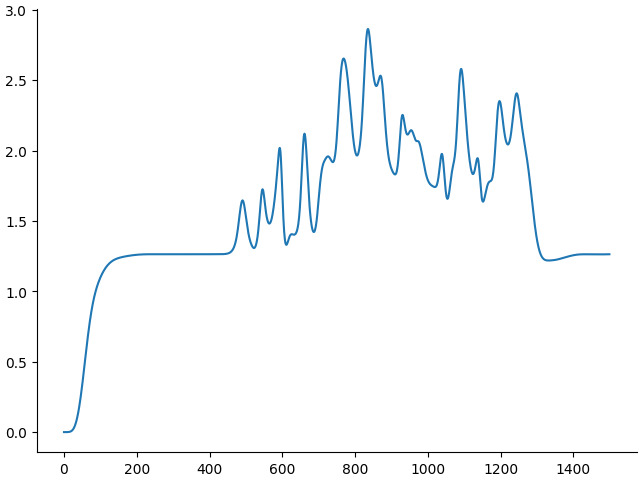

In [23]:
plt.plot(ve_rates[0])

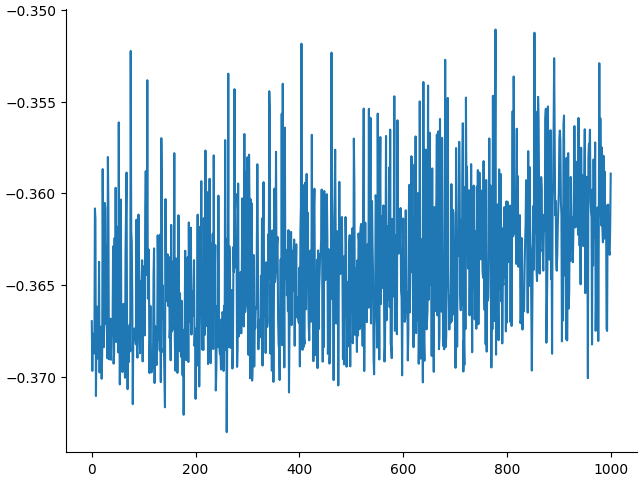

In [13]:
plt.plot(total_rewards)

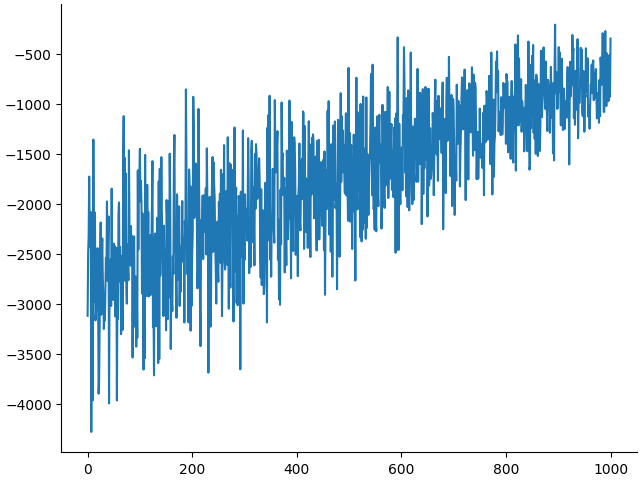

In [14]:
plt.plot(actor_losses)

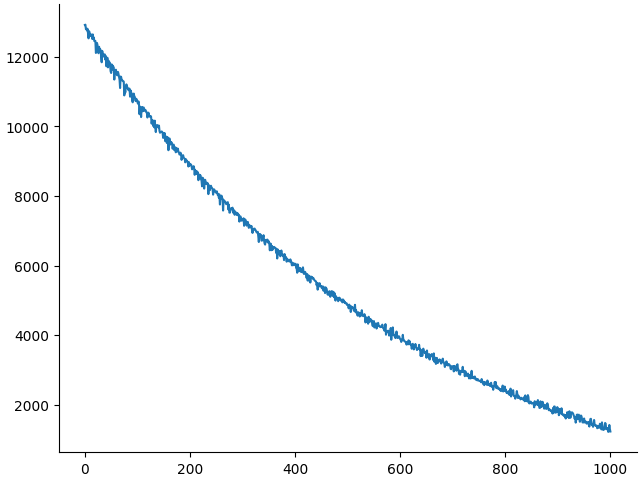

In [15]:
plt.plot(critic_losses)

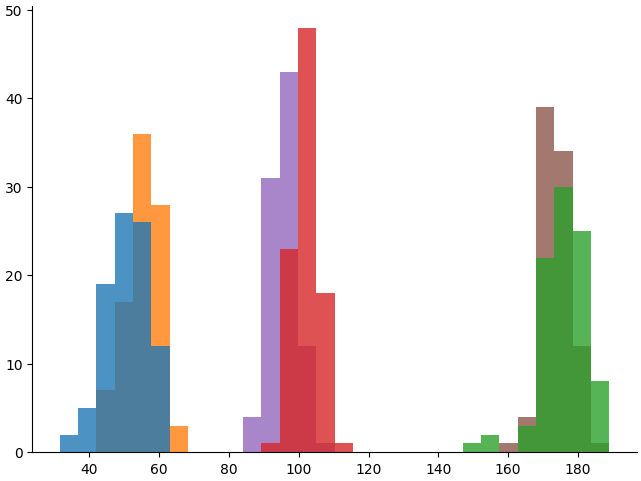

In [16]:
intervals = adult['syl_off'] - adult['syl_on']
plt.hist(intervals, histtype='stepfilled', alpha=0.8);

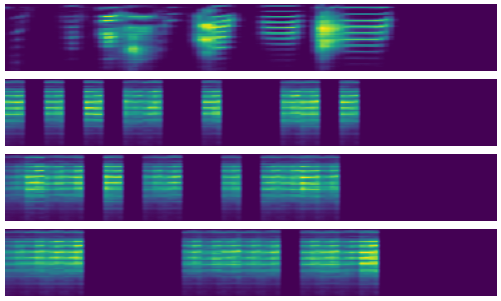

In [17]:
fig, ax = plt.subplots(4, figsize=(5, 3), sharex='all')
target = adult['spec_song'].mean(axis=0)
aux = np.zeros_like(songs[0])
aux[:,:target.shape[1]] = target
ax[0].imshow(aux)
ax[0].set_axis_off()
for i, j in enumerate((0, len(songs)//2, -1)):
    ax[i+1].imshow(songs[j], vmin=0)
    ax[i+1].set_axis_off()

In [18]:
plt.imshow(agent.actor_mean.data)
plt.colorbar()

AttributeError: 'ActorCritic' object has no attribute 'actor_mean'